# Natural Computing

This is an exercise from 2019/2 period of the course "Natural Computing" at UFES, in Vitória/ES - Brazil.

Task: Compare different nature-inspired optimization algorithms.

Master's degree candidate: Bruno Carvalho

## Algorithms

- GA - Genetic Algorithms
- PSO - Particle Swarm Optimization
- ES - Evolution Strategy


## References

.

In [1]:
import os
import sys
import time
import itertools
import random
import platform
import subprocess
import re

import psutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt

from benchmarks import *

%matplotlib inline
#%matplotlib notebook
%config InlineBackend.figure_format = 'png'


In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# System

In [3]:
def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode('utf-8').strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

In [4]:
mem = psutil.virtual_memory()
swap = psutil.swap_memory()
print('OS', os.name)
print('system', platform.system(), platform.release())
print('cpu', platform.processor())
print('processors', psutil.cpu_count(), get_processor_name())
print('memory', f'{(mem.total / 1024 / 1024 / 1024):4.1f} GB')
print('python', platform.python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('matplotlib', mpl.__version__)

OS posix
system Linux 5.0.0-27-generic
cpu x86_64
processors 6  Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
memory 31.3 GB
python 3.6.8
numpy 1.17.2
pandas 0.25.1
matplotlib 3.1.1


# Default parameters

In [5]:
#benchmarks = ['ackley_function', 'sphere_function', 'rastrigin_function', 'rosenbrock_function', 'schwefel']
benchmarks = ['ackley_function', 'sphere_function']

py_globals = globals()

execution_dict = {
    'time_elapsed': 0,
    'algorithm': '',
    'metrics': {
        'best': [],
        'all_best': 0.0,
        'all_worst': 0.0,
        'time': [],
        'objective': [],
        'scores': [],
    },
    'n_eval': 0,
    'max_eval': 0,
}

compare_cols = [
    'algorithm',
    'benchmark',
    'seed',
    'population',
    'dimension',
    'max_iter',
    'upper_bound',
    'lower_bound',
    'best',
    'worst',
    'mean',
    'time',
    'n_func_eval'
]
compare_data = pd.DataFrame(columns=compare_cols)

In [6]:
def ga_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/GA.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    population = parameters.get('population', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    best_to_keep = parameters.get('best_to_keep', 2)
    crossover_alpha = parameters.get('crossover_alpha', 0.25)
    max_eval = parameters.get('max_eval', 0)
    verbose = parameters.get('verbose', 0)
    
    np.random.seed(seed)
    
    # Input Objective function has variable dimensions
    # consider equi-distance "square"
    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    n_eval = 0
    
    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['scores'] = np.full([max_iterations, population], np.inf, dtype='float')

    begin = time.time()

    space = np.random.uniform(0, 1, [population, dimension])
    scores = np.random.uniform(0.0, 1.0, population)
    
    def crossover(space, scores):
        #population, dimension = space.shape
        search_space = np.zeros_like(space) + np.random.uniform(0, 1)
        #search_space = np.zeros_like(space)
        search_space[0:best_to_keep, :] = space[0:best_to_keep, :]
        
        # renew BETA every generation
        beta = np.random.uniform(-crossover_alpha, 1 + crossover_alpha)
        
        for cross  in range(best_to_keep + 1, population - 1, 2):

            # using SET parents will always be different
            #parents = set()
            
            # using LIST parents can repeat!
            parents = []
            
            parent1_idx = np.random.randint(0, population)
            parent2_idx = np.random.randint(0, population)
            
            parents.append(parent1_idx)
            parents.append(parent2_idx)

            """
            while len(parents) < 2:
                parent1_idx = np.random.randint(0, population)
                parent2_idx = np.random.randint(0, population)
            
                if scores[parent1_idx] > scores[parent2_idx]:
                    # p1 is better then p2
                    parents.add(parent1_idx)
                else:
                    parents.add(parent2_idx)               
            """
            
            lp = list(parents)
            parent1 = space[lp[0], :]
            parent2 = space[lp[1], :]
            
            # ARITHMETIC CROSSOVER
            child1 = parent1 * beta + (1.0 - beta) * parent2
            child2 = parent2 * beta + (1.0 - beta) * parent1
            
            crossover_chance = np.random.uniform(0.0, 1.0)

            if crossover_chance < crossover_rate:
                search_space[cross, :] = np.copy(child1)
                search_space[cross + 1, :] = np.copy(child2)  
            else:
                search_space[cross, :] = np.copy(parent1)
                search_space[cross + 1, :] = np.copy(parent2)
            
            for j in range(dimension):
                search_space[cross, j] = np.clip(search_space[cross, j], lower[j], upper[j])
                search_space[cross + 1, j] = np.clip(search_space[cross + 1, j], lower[j], upper[j])
                
        return search_space
    
    def mutation(space, gen):
        n_mutate = np.int(population * mutation_rate)
        for m in range(n_mutate):
            # keep best => do not mutate
            rand_individual = np.random.randint(best_to_keep + 1, population)
            #rand_individual = np.random.randint(0, population)
            # decrease stdev with generations
            #stdev = 5.0 / np.sqrt(gen + 1)
            stdev = 2
            new_value = np.zeros(dimension)
            for j in range(dimension):
                new_value[j] = np.random.normal(space[rand_individual, j], stdev)
                new_value[j] = np.clip(new_value[j], lower[j], upper[j])

            # store
            space[rand_individual, :] = new_value

        return space
    
    def sort_iter(_space, _scores):
        idx = scores.argsort()
        _space = _space[idx]
        _scores = _scores[idx]
        return _space, _scores
    
    def eval_obj(func, _space):
        _scores = np.full(population, np.inf)
        for p in range(population):
            _scores[p] = func(_space[p, :])
        return _scores

    for i in range(dimension):
        # init search space inside bounds
        space[:, i] = np.random.uniform(0, 1, population) * (upper[i] - lower[i]) + lower[i]
    
    for _iter in range(0, max_iterations):
        
        # crossover
        space = crossover(space, scores)
        
        # mutation
        space = mutation(space, _iter)
        
        # evaluate objective
        scores = eval_obj(obj_func, space)
        n_eval += population
        
        # remove duplicates
        
        # sort
        space, scores = sort_iter(space, scores)
        
        # save
        exec_info['metrics']['scores'][_iter] = scores
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = space[0, :]
        
        if verbose and _iter % np.int((max_iterations + 1) / 5) == 0:
            print(f'\t\tGen {_iter:06d}, '
                  f'f_min = {scores[0]:+13.5e}, '
            )

        #if max_eval > 0 and _iter > max_eval:
        #    break

    exec_info['algorithm'] = 'GA - Genetic Algorithm'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval
    
    return exec_info

In [7]:
def pso_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/PSO.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    velocity_max = np.full(dimension, parameters.get('velocity_max', 5.0))
    
    w_max = parameters.get('w_max', 0.9)
    w_min = parameters.get('w_min', 0.2)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')

    # inner variables
    
    c1 = 2.0
    c2 = 2.0
    
    velocity = np.full([population, dimension], 0.0)
    
    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)
    
    g_best_score = np.inf
    g_best = np.full(population, 0.0)
    
    space = np.full([population, dimension], 0.0)
    
    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        space[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]
    
    n_eval = 0
    for _iter in range(max_iterations):
        for _p in range(population):
            # keep inside bounds / search limits
            space[_p, :] = np.clip(space[_p, :], lower, upper)
            
            # eval
            score = obj_func(space[_p, :])
            n_eval += 1
            
            # check
            if p_best_score[_p] > score:
                p_best_score[_p] = score
                p_best[_p, :] = np.copy(space[_p, :])
            
            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(space[_p, :])
        
        w = w_max - _iter * ((w_max - w_min) / max_iterations)
        
        for _p in range(population):
            r1 = np.random.random([dimension])
            r2 = np.random.random([dimension])
            
            v = velocity[_p, :]
            
            a1 = c1 * r1 * (p_best[_p, :] - space[_p, :])
            a2 = c2 * r2 * (g_best - space[_p, :])
            
            velocity[_p, :] = w * v + a1 + a2
            
            velocity[_p, :] = np.fmax(velocity[_p, :], -velocity_max)  # negative!!
            velocity[_p, :] = np.fmin(velocity[_p, :],  velocity_max)
            
            # UPDATE space
            space[_p, :] += velocity[_p, :]

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score
        
        # some logging
        if _iter % np.int((max_iterations + 1) / 5.0) == 0:
            print(f'\t\tIteration {_iter:05d}, f_minx = {g_best_score:+12.5e}')

    # finished
    exec_info['algorithm'] = 'PSO - Particle Swarm Optimization'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval

    return exec_info

In [42]:
def bb_pso_optimizer(obj_func, parameters):
    """


    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    verbose = parameters.get('verbose', 0)

    np.random.seed(seed)

    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    exec_info['metrics']['scores'] = np.zeros(max_iterations, dtype='float')

    p_best_score = np.full(population, np.inf)
    p_best = np.full([population, dimension], 0.0)

    g_best_score = np.inf
    g_best = np.full(population, 0.0)

    begin = time.time()

    # init fill
    for _d in range(dimension):
        rand_dim = np.random.uniform(0, 1, population)
        p_best[:, _d] = rand_dim * (upper[_d] - lower[_d]) + lower[_d]

    n_eval = 0
    for _iter in range(max_iterations):
        for _p in range(population):

            # eval
            score = obj_func(p_best[_p, :])
            n_eval += 1

            # check
            if score < p_best_score[_p]:
                p_best_score[_p] = score

            if g_best_score > score:
                g_best_score = score
                g_best = np.copy(p_best[_p, :])

            # update positions
            mean = 0.5 * (g_best + p_best[_p, :])
            std = np.fabs(g_best - p_best[_p, :])
            tmp = np.random.normal(mean, std, dimension)
            p_best[_p, :] = np.clip(tmp, lower, upper)

        # save data to analyse and plot later
        exec_info['metrics']['scores'][_iter] = g_best_score

        # some logging
        if verbose and _iter % np.int((max_iterations + 1) / 5.0) == 0:
            print(f'\t\tIteration {_iter:05d}, f_minx = {g_best_score:+12.5e}')

    # finished
    exec_info['algorithm'] = 'BBPSO'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval

    return exec_info

In [9]:
def es_optimizer(obj_func, parameters):
    """
    
    Inspired by:
    
    """
    seed = parameters.get('seed', 1)
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    max_iterations = parameters.get('max_iterations', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    
    np.random.seed(seed)
    begin = time.time()
    n_eval = 0
    exec_info['algorithm'] = 'ES'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval

In [10]:
def cma_es_optimizer(obj_func, parameters):
    """
    
    Inspired by:
    https://github.com/jenkspt/CMA-ES

    """
    seed = parameters.get('seed', 1)
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    population = parameters.get('population', 100)
    max_iterations = parameters.get('max_iterations', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)

    
    np.random.seed(seed)
    begin = time.time()
    n_eval = 0
    exec_info['algorithm'] = 'CMA-ES'
    exec_info['time_elapsed'] = time.time() - begin
    exec_info['n_eval'] = n_eval

# GA - Genetic Algorithm

In [11]:
params = {
    'seed': 1,
    'dimension': 30,
    'max_iterations': 100,
    'population': 100,
    'upper': [30],
    'lower': [-30],
}

In [12]:
%lprun -T ga_lprof.txt -f ga_optimizer ga_optimizer(py_globals['ackley_function'], params)


*** Profile printout saved to text file 'ga_lprof.txt'. 


In [13]:
%%memit

results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 1000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'verbose': 1,
        }
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = ga_optimizer(py_globals[bmrk], params)
        results.append(tmp_result.copy())
        print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        print('\t\tf=', tmp_result['metrics']['scores'][-1][:3])
        #print('\tx=')
        #for xv in tmp_result['metrics']['best'][-1]:
        #    print(f'\t\t {xv:+12.7e}')
        #    pass

        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'GA',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )
print('')

Benchmark ackley_function
	Dimensions: 30, Seed=1
		Gen 000000, f_min =  +3.98924e+00, 
		Gen 000200, f_min =  +6.36001e-03, 
		Gen 000400, f_min =  +3.18091e-04, 
		Gen 000600, f_min =  +3.18091e-04, 
		Gen 000800, f_min =  +3.18091e-04, 
		Top 3 f(x) values, after   35.31s
		f= [3.18090537e-04 3.18090537e-04 1.09070522e+00]
Benchmark sphere_function
	Dimensions: 30, Seed=1
		Gen 000000, f_min =  +2.21689e+01, 
		Gen 000200, f_min =  +3.92370e-04, 
		Gen 000400, f_min =  +1.89315e-07, 
		Gen 000600, f_min =  +1.89315e-07, 
		Gen 000800, f_min =  +1.89315e-07, 
		Top 3 f(x) values, after   34.74s
		f= [1.89314808e-07 1.89314808e-07 5.16894766e-01]

peak memory: 107.39 MiB, increment: 2.20 MiB


In [14]:
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2][0])

Text(0, 0.5, 'log of f')

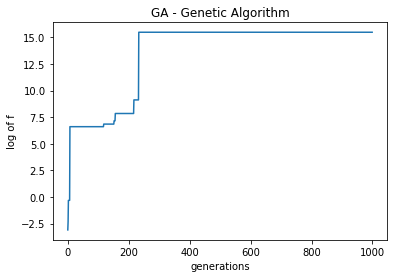

In [15]:
# change plot scale to LOG => better view
plt.plot(-np.log(y_plot))

plt.title('GA - Genetic Algorithm')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

In [16]:
pt = pd.pivot_table(
    compare_data[compare_data['algorithm'] == 'GA'],
    values=['best', 'worst', 'time', 'n_func_eval'],
    #values=['best'],
    index=['benchmark'],
    aggfunc={
        'best': [np.amin, np.amax],
        'worst': np.amax,
        'time': np.mean,
        'n_func_eval': np.amax
    }
)
print(pt)

                         best               n_func_eval       time worst
                         amax          amin        amax       mean  amax
benchmark                                                               
ackley_function  3.180905e-04  3.180905e-04      100000  35.310101   inf
sphere_function  1.893148e-07  1.893148e-07      100000  34.740786   inf


# PSO - Particle Swarm Optimization algorithm

In [17]:
results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 1000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
        }
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = pso_optimizer(ackley_function, params)
        results.append(tmp_result.copy())
        print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        print('\t\tf=', tmp_result['metrics']['scores'][-3:])

        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'PSO',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )

Benchmark function ackley_function
	Dimensions: 30, Seed=1
		Iteration 00000, f_minx = +1.99463e+01
		Iteration 00200, f_minx = +5.24985e+00
		Iteration 00400, f_minx = +3.07140e+00
		Iteration 00600, f_minx = +5.42037e-02
		Iteration 00800, f_minx = +2.52959e-04
		Top 3 f(x) values, after    4.60s
		f= [2.45367535e-08 2.35803168e-08 2.30137194e-08]
Benchmark function sphere_function
	Dimensions: 30, Seed=1
		Iteration 00000, f_minx = +2.04818e+01
		Iteration 00200, f_minx = +4.72920e+00
		Iteration 00400, f_minx = +2.37490e+00
		Iteration 00600, f_minx = +3.23256e-02
		Iteration 00800, f_minx = +4.21573e-05
		Top 3 f(x) values, after    4.53s
		f= [8.97398111e-09 8.65135918e-09 8.44193737e-09]


In [18]:
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

Text(0, 0.5, 'log of f')

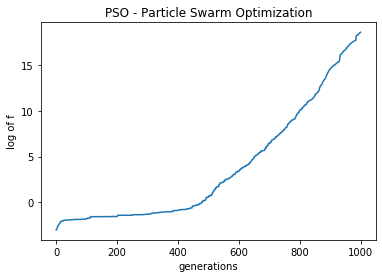

In [28]:
plt.plot(-np.log(y_plot))
plt.title('PSO - Particle Swarm Optimization')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

## BBPSO - Bare-bone Particle Swarm Optimization algorithm

Benchmark function ackley_function
	Dimensions: 30
	Iteration 00000, f_minx = +2.01560e+01
	Iteration 00400, f_minx = +4.17033e+00
	Iteration 00800, f_minx = +2.09590e-04
	Iteration 01200, f_minx = +1.82247e-08
	Iteration 01600, f_minx = +5.22693e-13
		Top 3 f(x) values, after    9.96s
		f= [5.01820807e-14 5.01820807e-14 5.01820807e-14]
Benchmark function sphere_function
	Dimensions: 30
	Iteration 00000, f_minx = +2.01560e+01
	Iteration 00400, f_minx = +4.17033e+00
	Iteration 00800, f_minx = +2.09590e-04
	Iteration 01200, f_minx = +1.82247e-08
	Iteration 01600, f_minx = +5.22693e-13
		Top 3 f(x) values, after   10.17s
		f= [5.01820807e-14 5.01820807e-14 5.01820807e-14]


Text(0, 0.5, 'log of f')

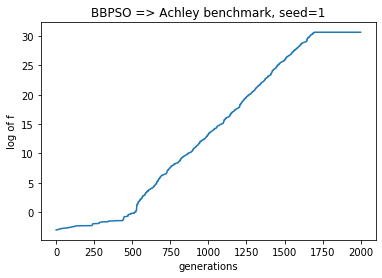

In [41]:
results = []
_dim = 30

for bmrk in benchmarks:
    print('Benchmark function', bmrk)
    for seed in range(1, 2):
        params = {
            'seed': seed,
            'dimension': _dim,
            'max_iterations': 2000,
            'population': 100,
            'upper': [30],
            'lower': [-30],
            'verbose': 1,
        }
        print(f'\tDimensions: {_dim}, Seed={seed}')
        tmp_result = bb_pso_optimizer(ackley_function, params)
        results.append(tmp_result.copy())
        print(f"\t\tTop 3 f(x) values, after {tmp_result['time_elapsed']:7.2f}s")
        print('\t\tf=', tmp_result['metrics']['scores'][-3:])

        compare_data = compare_data.append(
            pd.DataFrame(data=[[
                'BBPSO',
                bmrk,
                seed,
                params['population'],
                _dim,
                params['max_iterations'],
                params['upper'][0],
                params['lower'][0],
                np.amin(tmp_result['metrics']['scores'][-1]),
                np.inf,
                np.inf,
                tmp_result['time_elapsed'],
                tmp_result['n_eval']
            ]], columns=compare_cols),
            ignore_index=True
        )

r_dim = results[0] # seed=1, ackley
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

plt.plot(-np.log(y_plot))
plt.title('BBPSO => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

Text(0, 0.5, 'log of f')

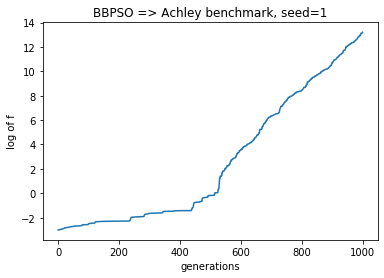

In [39]:
r_dim = results[0] # seed=1, ackley
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2])

plt.plot(-np.log(y_plot))
plt.title('BBPSO => Achley benchmark, seed=1')
#plt.subtitle('log of f(x) for x = best')
plt.xlabel('generations')
plt.ylabel('log of f')

# ES - Evolutionary Strategy algorithm

In [21]:
0

0

# CMA-ES - Covariance Matrix Evolutionary Strategy algorithm

# Direct comparison

Compare results for each benchmark function.

In [22]:
pt = pd.pivot_table(
    compare_data,
    #values=['best', 'worst', 'time', 'n_func_eval'],
    values=['best', 'time', 'n_func_eval'],
    index=['benchmark', 'algorithm'],
    aggfunc={
        'best': [np.amin, np.amax],
        #'worst': np.amax,
        'time': np.mean,
        'n_func_eval': np.amax
    }
)
print(pt)

                                   best               n_func_eval       time
                                   amax          amin        amax       mean
benchmark       algorithm                                                   
ackley_function GA         3.180905e-04  3.180905e-04      100000  35.310101
                PSO        2.301372e-08  2.301372e-08      100000   4.600862
sphere_function GA         1.893148e-07  1.893148e-07      100000  34.740786
                PSO        8.441937e-09  8.441937e-09      100000   4.533197


In [23]:
print(type(pt))

<class 'pandas.core.frame.DataFrame'>


In [24]:
print(pt.columns)

MultiIndex([(       'best', 'amax'),
            (       'best', 'amin'),
            ('n_func_eval', 'amax'),
            (       'time', 'mean')],
           )


In [25]:
colors = {
    'ackley_function': 'b',
    'sphere_function': 'r'
}
markers = {
    'GA': 's',
    'PSO': 'o'
}

for i in range(pt.shape[0]):
    f = pt.iloc[i, pt.columns.gel_loc('benchmark')]
    a = pt.iloc[i, pt.gel_loc('algorithm')]
    plot(pt.iloc[i, pt.gel_loc('time')],
         pt.iloc[i, pt.gel_loc('amax')],
         color=colors[f], marker=markers[a], linestyle='none', markersize=12)

AttributeError: 'MultiIndex' object has no attribute 'gel_loc'